# Nonlinear Classification - Double Moon Problem
## EEE511 Assignment 2

## Step 1: Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0+cpu
Device: cpu


## Step 2: Data Loading and Preparation

In [2]:
data = pd.read_csv('c:/Users/latik/Downloads/2halfmoonsTrain.csv')

print("Dataset Information:")
print(f"Shape: {data.shape}")
print(f"\nFirst few rows:\n{data.head()}")
print(f"\nClass distribution (original):")
print(data['ClassLabel'].value_counts())

Dataset Information:
Shape: (800, 3)

First few rows:
          X         Y  ClassLabel
0  0.305885 -0.676524           2
1 -0.203136 -0.331768           2
2  0.018577  1.204987           1
3 -0.282424 -0.292532           2
4  1.093037  0.515905           1

Class distribution (original):
ClassLabel
2    400
1    400
Name: count, dtype: int64


In [3]:
X = data[['X', 'Y']].values
y = data['ClassLabel'].values
y = y - 1

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels after remapping: {np.unique(y)}")


Features shape: (800, 2)
Labels shape: (800,)
Unique labels after remapping: [0 1]


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")


Training set size: 640 samples (80.0%)
Validation set size: 160 samples (20.0%)


In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

print(f"\nTensor shapes:")
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}")
print(f"y_val: {y_val_tensor.shape}")


Tensor shapes:
X_train: torch.Size([640, 2])
y_train: torch.Size([640, 1])
X_val: torch.Size([160, 2])
y_val: torch.Size([160, 1])


## Step 3: Defining the MLP Model Architecture

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MLP(input_size=2, hidden_size=16, output_size=1)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 65


## Step 4: Setting Hyperparameters

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 2000

print("Hyperparameters:")
print(f"Loss Function: Binary Cross-Entropy (BCELoss)")
print(f"Optimizer: Adam")
print(f"Learning Rate: 0.001")
print(f"Weight Decay (L2): 1e-5")
print(f"Number of Epochs: {num_epochs}")

Hyperparameters:
Loss Function: Binary Cross-Entropy (BCELoss)
Optimizer: Adam
Learning Rate: 0.001
Weight Decay (L2): 1e-5
Number of Epochs: 2000


## Step 5: Training Loop with Validation

In [8]:
torch.manual_seed(42)
model = MLP(input_size=2, hidden_size=16, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Model reinitialized for fresh training\n")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()
    
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    predictions_train = (outputs_train >= 0.5).float()
    train_accuracy = (predictions_train == y_train_tensor).float().mean().item()
    
    train_losses.append(loss_train.item())
    train_accuracies.append(train_accuracy)
    
    model.eval()
    
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor)
        
        predictions_val = (outputs_val >= 0.5).float()
        val_accuracy = (predictions_val == y_val_tensor).float().mean().item()
        
        val_losses.append(loss_val.item())
        val_accuracies.append(val_accuracy)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {loss_train.item():.4f}, Train Acc: {train_accuracy*100:.2f}%")
        print(f"  Val Loss: {loss_val.item():.4f}, Val Acc: {val_accuracy*100:.2f}%")
        print()

print("Training completed!")
print(f"\nFinal Training Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")

Model reinitialized for fresh training

Starting training...

Epoch [200/2000]
  Train Loss: 0.3789, Train Acc: 85.31%
  Val Loss: 0.3829, Val Acc: 83.75%



Epoch [400/2000]
  Train Loss: 0.2532, Train Acc: 90.47%
  Val Loss: 0.2579, Val Acc: 90.00%

Epoch [600/2000]
  Train Loss: 0.2077, Train Acc: 91.09%
  Val Loss: 0.2051, Val Acc: 91.25%

Epoch [800/2000]
  Train Loss: 0.1858, Train Acc: 90.78%
  Val Loss: 0.1768, Val Acc: 93.12%

Epoch [1000/2000]
  Train Loss: 0.1706, Train Acc: 91.87%
  Val Loss: 0.1576, Val Acc: 94.38%

Epoch [1200/2000]
  Train Loss: 0.1568, Train Acc: 92.19%
  Val Loss: 0.1416, Val Acc: 94.38%

Epoch [1400/2000]
  Train Loss: 0.1431, Train Acc: 92.97%
  Val Loss: 0.1267, Val Acc: 94.38%

Epoch [1600/2000]
  Train Loss: 0.1293, Train Acc: 93.44%
  Val Loss: 0.1123, Val Acc: 96.25%

Epoch [1800/2000]
  Train Loss: 0.1154, Train Acc: 94.22%
  Val Loss: 0.0984, Val Acc: 97.50%

Epoch [2000/2000]
  Train Loss: 0.1013, Train Acc: 95.16%
  Val Loss: 0.0852, Val Acc: 98.75%

Training completed!

Final Training Accuracy: 95.16%
Final Validation Accuracy: 98.75%


## Step 6: Plot Learning Curve

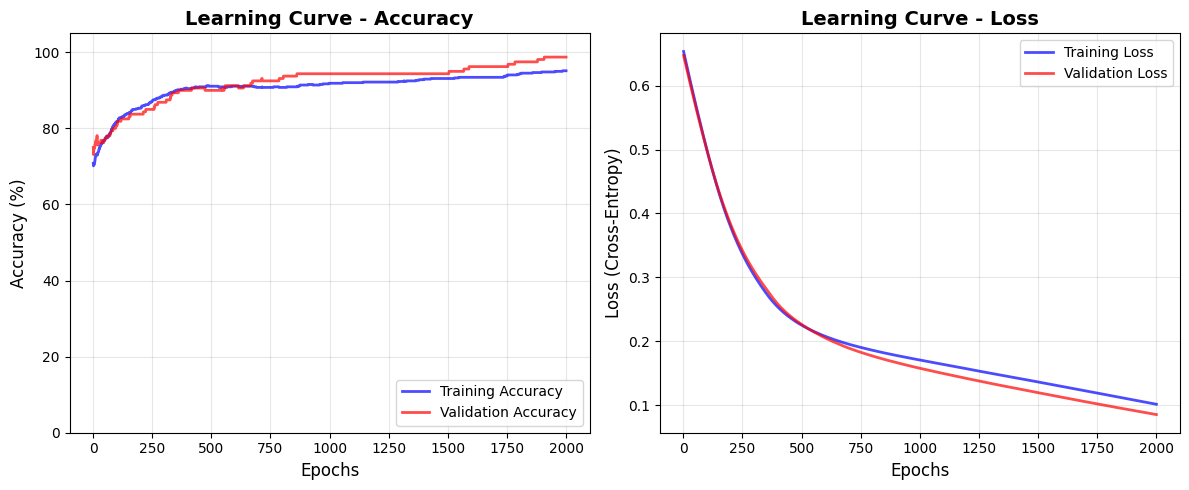

Learning curve saved as 'learning_curve.png'


In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in train_accuracies], 
         label='Training Accuracy', linewidth=2, color='blue', alpha=0.7)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in val_accuracies], 
         label='Validation Accuracy', linewidth=2, color='red', alpha=0.7)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Learning Curve - Accuracy', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 105])

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, 
         label='Training Loss', linewidth=2, color='blue', alpha=0.7)
plt.plot(range(1, num_epochs + 1), val_losses, 
         label='Validation Loss', linewidth=2, color='red', alpha=0.7)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Cross-Entropy)', fontsize=12)
plt.title('Learning Curve - Loss', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curve saved as 'learning_curve.png'")

## Step 7: Plot Decision Boundary

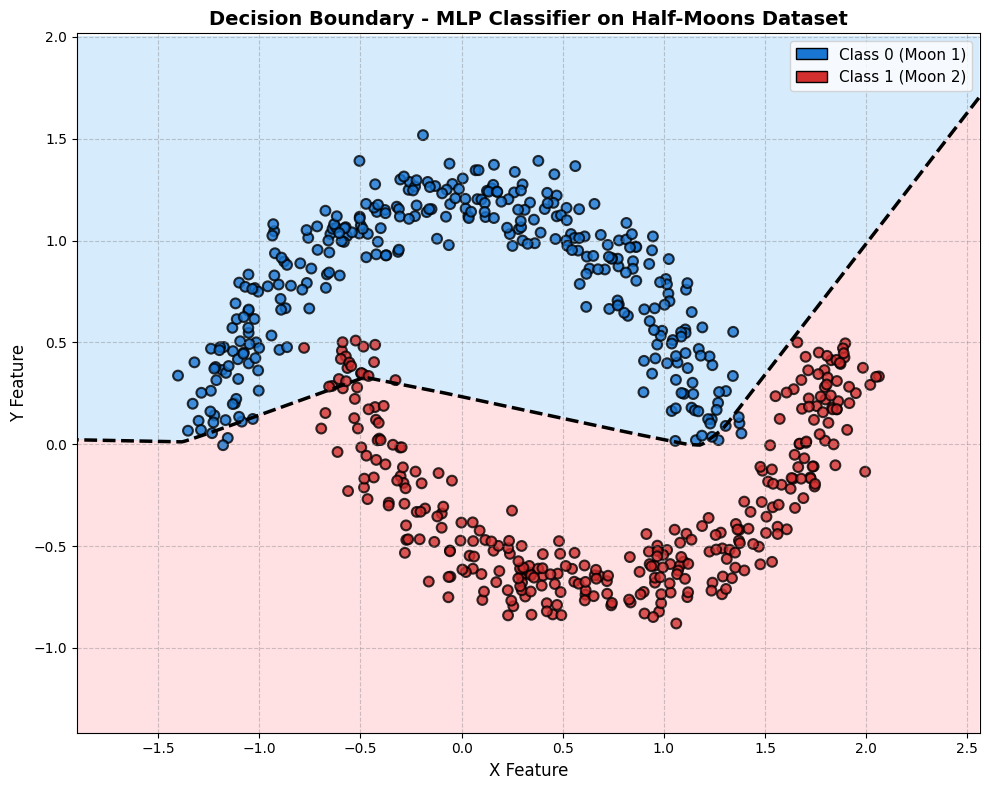

Decision boundary plot saved as 'decision_boundary.png'


In [10]:
from matplotlib.patches import Patch

model.eval()

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

mesh_data = np.c_[xx.ravel(), yy.ravel()]
mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32)

with torch.no_grad():
    Z = model(mesh_tensor)
    Z = Z.numpy().reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['#BBDEFB', '#FFCDD2'], alpha=0.6)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')

colors = ['#1976D2', '#D32F2F']
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], 
                     c=[colors[int(label)] for label in y_train],
                     edgecolors='black', s=50, alpha=0.8, linewidths=1.5)

legend_elements = [Patch(facecolor=colors[0], edgecolor='black', label='Class 0 (Moon 1)'),
                   Patch(facecolor=colors[1], edgecolor='black', label='Class 1 (Moon 2)')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.xlabel('X Feature', fontsize=12)
plt.ylabel('Y Feature', fontsize=12)
plt.title('Decision Boundary - MLP Classifier on Half-Moons Dataset', 
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()

plt.savefig('decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Decision boundary plot saved as 'decision_boundary.png'")

## Step 8: Model Evaluation

In [11]:
print("FINAL MODEL EVALUATION")
print("="*60)

print(f"\nTraining Accuracy:      {train_accuracies[-1]*100:.2f}%")
print(f"Validation Accuracy:    {val_accuracies[-1]*100:.2f}%")
print(f"Training Loss:          {train_losses[-1]:.4f}")
print(f"Validation Loss:        {val_losses[-1]:.4f}")

epochs_to_95 = next((i for i, acc in enumerate(val_accuracies) if acc >= 0.95), num_epochs)
print(f"\nEpochs to 95% accuracy: {epochs_to_95 + 1}")
print(f"Total Parameters:       {sum(p.numel() for p in model.parameters())}")


FINAL MODEL EVALUATION

Training Accuracy:      95.16%
Validation Accuracy:    98.75%
Training Loss:          0.1013
Validation Loss:        0.0852

Epochs to 95% accuracy: 1568
Total Parameters:       65
